HBox(children=(RadioButtons(description='Speed: ', index=1, options=('Wpm', 'Adjusted-Wpm'), value='Adjusted-Wpm'), RadioButtons(description='Accuracy: ', options=('Total-Error-Rate', 'Uncorrected-Error-Rate', 'Corrected-Error-Rate'), value='Total-Error-Rate')))

ToggleButtons(description='Metric: ', index=4, options=('Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed Vs. Accuracy'), value='Speed Vs. Accuracy')

HBox(children=(Select(description='Participant: ', index=5, options=('All', '#1', '#2', '#3', '#4', '#5'), value='#5'),))

<IPython.core.display.Javascript object>


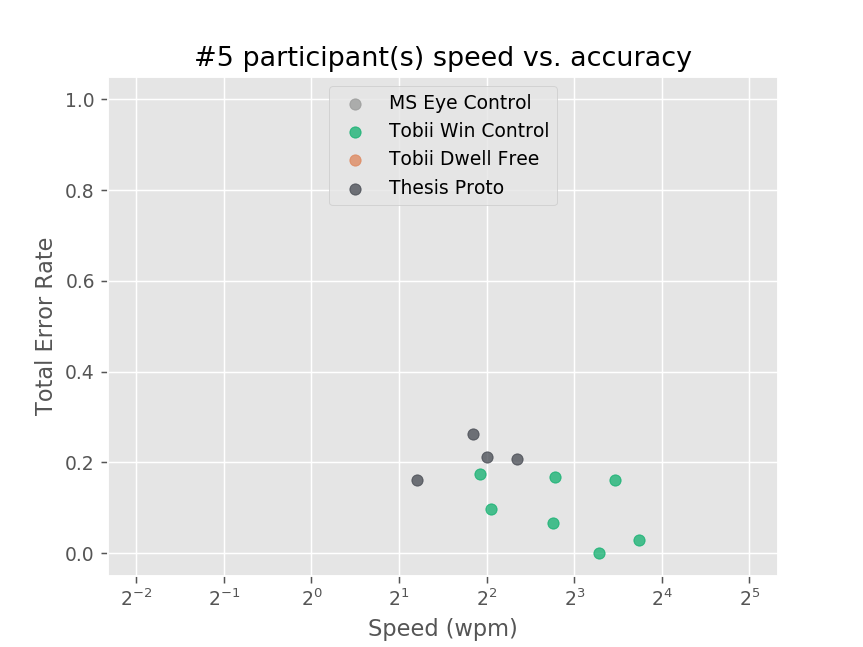

In [8]:
# Keyboard ordering:
# eyeControl 0
# winControl 1
# dwellFree 2
# myProto 3

%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np

class Sentence:
	def __init__(self, participant, sentenceNo, testing, keyboard):
		self.participant = participant
		self.sentenceNo = sentenceNo
		self.testing = testing
		self.keyboard = keyboard
		self.wpm = 0.0
		self.adjWpm = 0.0
		self.totErrRate = 0.0
		self.uncErrRate = 0.0
		self.corErrRate = 0.0

class IO:
	def ReadSentences(_filename):
		with open('Raw-Data/Logs/' + _filename + '.csv') as csvDataFile:
			csvReader = csv.reader(csvDataFile)
			next(csvReader, None)
			next(csvReader, None)
			for row in csvReader:
				Sentences.append(Sentence(int(_filename[11]), int(row[0]), int(row[1]), int(_filename[18])))
				# exclude exceptions that the test participant didn't enter anything and skipped this sentence			
				if row[3] != 0:			
					Sentences[-1].wpm = float(row[3])
					Sentences[-1].adjWpm = float(row[4])
					Sentences[-1].totErrRate = float(row[11])
					Sentences[-1].uncErrRate = float(row[9])
					Sentences[-1].corErrRate = float(row[10])

class UserControl:
	def __init__(self):
		self.contrSpeed = widgets.RadioButtons(
			options=['Wpm', 'Adjusted-Wpm'],
			description='Speed: ',
			value='Wpm',
			disabled=False
			)
		self.contrErrRate = widgets.RadioButtons(
			options=['Total-Error-Rate', 'Uncorrected-Error-Rate', 'Corrected-Error-Rate'],
			description='Accuracy: ',
			value='Total-Error-Rate',
			disabled=False
			)
		self.contrMetric = widgets.ToggleButtons(
			options=['Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve', 'Speed Vs. Accuracy'],
			description='Metric: ',
			value='Learning Curve',
			disabled=False
			)
		self.contrPtcp = widgets.Select(
			options=['All', '#1', '#2', '#3', '#4', '#5'],
			description='Participant: ',
			value='All',
			disabled=False
			)
		display(widgets.HBox([self.contrSpeed, self.contrErrRate]), self.contrMetric, widgets.HBox([self.contrPtcp]))
		self.contrMetric.observe(self.onChange_plot)
		self.contrPtcp.observe(self.onChange_plot)
		self.contrSpeed.observe(self.onChange_plot)
		self.contrErrRate.observe(self.onChange_plot)

	def onChange_plot(self, b):
		if b['type']=='change' and b['name']=='value':
			self.clearCache()
			# extract sentences according to participant selection
			for sentence in Sentences:
				if sentence.testing == 1:
					if self.contrPtcp.value != 'All':
						index = (int(self.contrPtcp.value[1])-1)*amountKeyboard + sentence.keyboard
						selectedPtcp = [int(self.contrPtcp.value[1])]
					else:
						index = sentence.participant*amountKeyboard + sentence.keyboard
						selectedPtcp = [i for i in range(amountPtcp)]
					if sentence.participant in selectedPtcp:
						perPtcpWpm[index].append(sentence.wpm)
						perPtcpAdjWpm[index].append(sentence.adjWpm)
						perPtcpTotErrRate[index].append(sentence.totErrRate)
						perPtcpUncErrRate[index].append(sentence.uncErrRate)
						perPtcpCorErrRate[index].append(sentence.corErrRate)
						perPtcpSentenceNo[index].append(sentence.sentenceNo)						
			self.filter()
			if 'Speed' == self.contrMetric.value:
				plot.plotSpeed()
			elif 'Accuracy' == self.contrMetric.value:
				plot.plotAccuracy()
			elif 'Speed & Accuracy' == self.contrMetric.value:
				plot.plotSpeedNAccuracy()
			elif 'Learning' in self.contrMetric.value:
				plot.plotLearningCurve()
			elif 'Speed Vs. Accuracy' == self.contrMetric.value:
				plot.plotSpeedVsAccuracy()	

	def filter(self):
		# TODO: remove outliers that out of 90%
		pass

	def clearCache(self):
		clear_output(wait=True)
		display(widgets.HBox([self.contrSpeed, self.contrErrRate]), self.contrMetric, widgets.HBox([self.contrPtcp]))
		# clear data storage
		dataStorage = [perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo]
		for item in dataStorage:
			for index in range(amountPtcp*amountKeyboard):
				del item[index][:]
				pass

class Plot:
	plotXPosition = [1,2,3,4]
	labelKeybd = ['MS Eye Control', 'Tobii Win Control', 'Tobii Dwell Free', 'Thesis Proto'] * 6
	axisKeybd = ['MS\nEye Control', 'Tobii\nWin Control', 'Tobii\nDwell Free', 'Thesis\nProto'] * 6
	color = ['#939493', '#01ac66', '#DD7E50', '#393D46'] * 6 

	def plotSpeed(cls):
		fig, ax = plt.subplots()
		ax.set(title = ui.contrPtcp.value + ' participant(s)' + ' typing speed', ylabel = 'Entry Speed (wpm)')
		plt.ylim(-1,25)
		yWpm = [[] for i in range(amountKeyboard)]
		if ui.contrSpeed.value == 'Wpm':
			plotPerPtcpWpm = perPtcpWpm
		elif ui.contrSpeed.value == 'Adjusted-Wpm':
			plotPerPtcpWpm = perPtcpAdjWpm
		for index in range(len(plotPerPtcpWpm)):
			for subIndex in range(len(plotPerPtcpWpm[index])):
				yWpm[index%amountKeyboard].append(plotPerPtcpWpm[index][subIndex])
		for i in range(amountKeyboard):
			plt.boxplot(yWpm[i], positions=[cls.plotXPosition[i]], showfliers=True, patch_artist=True, 
						boxprops=dict(facecolor=cls.color[i]), medianprops=dict(linewidth=1, linestyle=None, color='white'))
		plt.xlim(min(cls.plotXPosition)-1, max(cls.plotXPosition)+1)	
		plt.xticks(cls.plotXPosition, cls.axisKeybd)
		fig.savefig('plotSpeed_' + ui.contrPtcp.value+'.png', bbox_inches='tight')

	def plotAccuracy(cls):
		fig, ax = plt.subplots()
		ax.set(title=ui.contrPtcp.value+' participant(s)'+' typing error rate', ylabel='Error Rate')
		plt.ylim(-0.1,1.1)
		yErrRate = [[] for i in range(amountKeyboard)]
		if ui.contrErrRate.value == 'Total-Error-Rate':
			plotPerPtcpErrRate = perPtcpTotErrRate
		elif ui.contrErrRate.value == 'Uncorrected-Error-Rate':
			plotPerPtcpErrRate = perPtcpUncErrRate
		elif cui.ontrErrRate.value == 'Corrected-Error-Rate':
			plotPerPtcpErrRate = perPtcpCorErrRate
		for index in range(len(plotPerPtcpErrRate)):
			for subIndex in range(len(plotPerPtcpErrRate[index])):
				yErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][subIndex])
		for i in range(amountKeyboard):
			plt.boxplot(yErrRate[i], positions=[cls.plotXPosition[i]], showfliers=True, patch_artist=True, 
						boxprops=dict(facecolor=cls.color[i]), medianprops=dict(linewidth=1, linestyle=None, color='white'))
		plt.xlim(min(cls.plotXPosition)-1, max(cls.plotXPosition)+1)	
		plt.xticks(cls.plotXPosition, cls.axisKeybd)
		fig.savefig('plotErrorRate_'+ui.contrPtcp.value+'.png', bbox_inches='tight')

	def plotSpeedNAccuracy(cls):
		fig, ax = plt.subplots()
		ax.set(title=ui.contrPtcp.value+' participant(s)'+' typing speed with error rate', ylabel='Entry Speed (wpm)')
		plt.ylim(0,20)
		yWpm, sdTotErrRate = ([[] for i in range(amountKeyboard)] for j in range(2))
		if ui.contrSpeed.value == 'Wpm':
			plotPerPtcpWpm = perPtcpWpm
		elif ui.contrSpeed.value == 'Adjusted-Wpm':
			plotPerPtcpWpm = perPtcpAdjWpm
		if ui.contrErrRate.value == 'Total-Error-Rate':
			plotPerPtcpErrRate = perPtcpTotErrRate
		elif ui.contrErrRate.value == 'Uncorrected-Error-Rate':
			plotPerPtcpErrRate = perPtcpUncErrRate
		elif ui.contrErrRate.value == 'Corrected-Error-Rate':
			plotPerPtcpErrRate = perPtcpCorErrRate
		for index in range(len(plotPerPtcpWpm)):
			for subIndex in range(len(plotPerPtcpWpm[index])):
				yWpm[index%amountKeyboard].append(plotPerPtcpWpm[index][subIndex])
				sdTotErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][subIndex])
		for i in range(amountKeyboard):
			plt.bar(i+1,np.mean(yWpm[i]),0.5,color=cls.color[i],label=cls.labelKeybd[i],alpha=0.7)		
		for i in range(amountKeyboard):
			if i == 0:
				eb = plt.errorbar(i+1,np.mean(yWpm[i]),np.mean(sdTotErrRate[i])*np.mean(yWpm[i]),
							color='gray',elinewidth=1,capsize=3,label='Associated standard deviation')
			else:
				eb = plt.errorbar(i+1,np.mean(yWpm[i]),np.mean(sdTotErrRate[i])*np.mean(yWpm[i]),
							color='gray',elinewidth=1,capsize=3)
			eb[-1][0].set_linestyle('--')
		plt.xlim(min(cls.plotXPosition)-1, max(cls.plotXPosition)+1)	
		plt.xticks(cls.plotXPosition, cls.axisKeybd)
		ax.legend(loc='upper center')	
		fig.savefig('plotSpeedNAccuracy_'+ui.contrPtcp.value+'.png', bbox_inches='tight')

	def plotLearningCurve(cls):
		fig, ax = plt.subplots()
		if ui.contrSpeed.value == 'Wpm':
			plotPerPtcpWpm = perPtcpWpm
		elif ui.contrSpeed.value == 'Adjusted-Wpm':
			plotPerPtcpWpm = perPtcpAdjWpm
		if ui.contrErrRate.value == 'Total-Error-Rate':
			plotPerPtcpErrRate = perPtcpTotErrRate
		elif ui.contrErrRate.value == 'Uncorrected-Error-Rate':
			plotPerPtcpErrRate = perPtcpUncErrRate
		elif ui.contrErrRate.value == 'Corrected-Error-Rate':
			plotPerPtcpErrRate = perPtcpCorErrRate
			
		if ui.contrPtcp.value != 'All':
			for index in range(len(plotPerPtcpWpm)):
				if len(plotPerPtcpWpm[index]):
					sdError = [a*b for a,b in zip(plotPerPtcpWpm[index], plotPerPtcpErrRate[index])]
					eb = plt.errorbar(perPtcpSentenceNo[index],plotPerPtcpWpm[index],sdError,
						fmt='.-',color=cls.color[index],elinewidth=6,capsize=3,label=cls.labelKeybd[index],alpha=0.7)
					# eb[-1][0].set_linestyle('--')
		else:
			yPerSentenceWpm, yPerSentenceTotErrRate = ([[([0]*15) for i in range(amountPtcp)] for j in range(amountKeyboard)] for k in range(2))
			tmpPerSentenceNo = [j for j in range(4,19)]
			for index in range(len(plotPerPtcpWpm)):
				for indexSub in range(len(plotPerPtcpWpm[index])):
					i = tmpPerSentenceNo.index(perPtcpSentenceNo[index][indexSub])
					yPerSentenceWpm[index%amountKeyboard][index//amountKeyboard][i] = plotPerPtcpWpm[index][indexSub]
					yPerSentenceTotErrRate[index%amountKeyboard][index//amountKeyboard][i] = plotPerPtcpErrRate[index][indexSub]
			yWpm, sdTotErrRate = ([([0]*15)for p in range(amountKeyboard)] for q in range(2))
			for i in range(amountKeyboard):
				for j in range(15):
					bufferWpm, bufferErrRate = ([] for q in range(2))
					for k in range(amountPtcp):
						if yPerSentenceWpm[i][k][j] != 0:
							bufferWpm.append(yPerSentenceWpm[i][k][j])
							bufferErrRate.append(yPerSentenceTotErrRate[i][k][j])
					if len(bufferWpm) <= amountPtcp: # threshold = 0.3
						yWpm[i][j] = np.mean(bufferWpm)
						sdTotErrRate[i][j] = np.mean(bufferErrRate)
					else:
						yWpm[i][j] = 0
						sdTotErrRate[i][j] = 0
				eb = plt.errorbar([q for q in range(4,19)], yWpm[i], sdTotErrRate[i],
								fmt='.-',color=cls.color[i],elinewidth=6,capsize=3,label=cls.labelKeybd[i],alpha=0.5)
				# eb[-1][0].set_linestyle('--')
		ax.legend(loc='upper center')
		ax.set(title=ui.contrPtcp.value+' participant(s)'+' learning curve', xlabel='Sentence no.', ylabel='Entry speed (wpm)')
		plt.ylim(0, 26)
		fig.savefig('plotLearningCurve_'+ui.contrPtcp.value+'.png', bbox_inches='tight')
	
	def plotSpeedVsAccuracy(cls):
		xSpeed, yErrRate = ([[], [], [], []] for i in range(2))
		if ui.contrSpeed.value == 'Wpm':
			plotPerPtcpWpm = perPtcpWpm
		elif ui.contrSpeed.value == 'Adjusted-Wpm':
			plotPerPtcpWpm = perPtcpAdjWpm
		if ui.contrErrRate.value == 'Total-Error-Rate':
			plotPerPtcpErrRate = perPtcpTotErrRate
		elif ui.contrErrRate.value == 'Uncorrected-Error-Rate':
			plotPerPtcpErrRate = perPtcpUncErrRate
		elif ui.contrErrRate.value == 'Corrected-Error-Rate':
			plotPerPtcpErrRate = perPtcpCorErrRate
		for index in range(len(plotPerPtcpWpm)):
			if len(plotPerPtcpWpm[index]):
				for indexSub in range(len(plotPerPtcpWpm[index])):
					xSpeed[index%amountKeyboard].append(plotPerPtcpWpm[index][indexSub])
					yErrRate[index%amountKeyboard].append(plotPerPtcpErrRate[index][indexSub])
		fig, ax = plt.subplots()
		for i in range(amountKeyboard):
			plt.scatter(xSpeed[i], yErrRate[i], color=cls.color[i], label=cls.labelKeybd[i], alpha=0.7)
		ax.legend(loc='upper center')
		ax.set_xscale('log', basex=2)
		ax.set(title=ui.contrPtcp.value+' participant(s)'+' speed vs. accuracy', xlabel='Speed (wpm)', ylabel='Total Error Rate')
		plt.ylim(-0.05, 1.05)
		plt.xlim(0.2,40)
		fig.savefig('plotSpeedVsAccuracy_'+ui.contrPtcp.value+'.png', bbox_inches='tight')

if __name__ == "__main__":
	amountPtcp = 5
	amountKeyboard = 4
	Sentences = []
	perPtcpWpm, perPtcpAdjWpm, perPtcpTotErrRate, perPtcpUncErrRate, perPtcpCorErrRate, perPtcpSentenceNo = ([[] for j in range(amountPtcp*amountKeyboard)] for i in range(6))
	filenames = [					 'Participant1_Keybd1', 'Participant1_Keybd2', 'Participant1_Keybd3',
									 'Participant2_Keybd1', 'Participant2_Keybd2', 'Participant2_Keybd3',
										'Participant3_Keybd3',
				'Participant4_Keybd0', 'Participant4_Keybd1', 						'Participant4_Keybd3',
				'Participant5_Keybd0', 'Participant5_Keybd1', 						'Participant5_Keybd3']

	for filename in filenames:
		IO.ReadSentences(filename)

	ui = UserControl()
	plot = Plot()

	# TODO: compute ANOVA

